GBDT系のハイパラ探索用

In [1]:
!pip install optuna catboost
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from pytz import timezone
from datetime import datetime, timedelta
import json
import itertools
from tqdm import tqdm
import os
os.chdir("/content/drive/MyDrive/projects/table_stan")
import xgboost as xgb
import lightgbm as lgb
import catboost as cat
from sklearn.metrics import mean_squared_log_error, mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, train_test_split
import optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from sklearn.model_selection import KFold, train_test_split

data = pd.read_csv("data/train.csv")
X_sub = pd.read_csv("data/test.csv")
df_sub = pd.DataFrame({"id":np.arange(len(X_sub))})

In [15]:
target = "cost"
random_state = 13
test_size = 0.1
n_splits = 5
num_boost_round = 1000
stopping_rounds = 50
n_trials = 100
drop_columns = ["cost"]
model_name = "XGBoost"

X_train, X_test, y_train, y_test = train_test_split(data.drop(target, axis=1), data[target], test_size=test_size, random_state=random_state)
df_train = pd.DataFrame(pd.concat([X_train, y_train], axis=1), columns=data.columns)
df_test = pd.DataFrame(pd.concat([X_test, y_test], axis=1), columns=data.columns)

In [16]:
display(df_train.head())
display(df_test.head())

,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
26554,8.50,5.0,3.0,1.0,3.0,11.20,1.0,0.0,28.0,23598.0,0.0,0.0,0.0,0.0,1.0,101.84
37713,1.80,3.0,1.0,0.0,2.0,19.90,1.0,0.0,24.0,23759.0,1.0,0.0,1.0,1.0,1.0,89.90
32430,7.28,4.0,4.0,0.0,1.0,12.50,1.0,0.0,34.0,23759.0,1.0,0.0,1.0,1.0,1.0,89.90
28301,4.26,3.0,3.0,3.0,3.0,7.31,1.0,1.0,8.0,33858.0,1.0,0.0,1.0,1.0,1.0,136.74
1611,3.33,3.0,5.0,0.0,1.0,17.30,1.0,1.0,6.0,21215.0,1.0,0.0,0.0,0.0,0.0,135.80


,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
30798,5.13,3.0,3.0,2.0,3.0,20.90,0.0,1.0,23.0,21215.0,1.0,0.0,0.0,0.0,0.0,123.88
44160,4.44,3.0,2.0,2.0,2.0,14.00,0.0,0.0,34.0,23598.0,0.0,0.0,0.0,0.0,1.0,122.51
25844,8.73,3.0,2.0,0.0,2.0,21.80,1.0,0.0,10.0,30797.0,1.0,1.0,1.0,1.0,1.0,76.88
48597,8.88,3.0,5.0,2.0,2.0,9.96,0.0,1.0,32.0,30584.0,1.0,1.0,1.0,1.0,1.0,86.79
10109,6.39,3.0,5.0,1.0,3.0,17.00,0.0,0.0,35.0,30268.0,0.0,0.0,0.0,0.0,0.0,98.52


In [17]:
def lgbm_objective(trial):
    param = {
        "objective": "regression",
        "metric": "rmse",
        "random_state": random_state,
        "verbose": -1,
        "learning_rate": 0.1,
        "max_depth": trial.suggest_int("max_depth", 3, 9),
        "num_leaves": trial.suggest_int("num_leaves", 2, 512),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 0, 300), 
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "max_bin" : trial.suggest_int("max_bin", 32, 512),
        "subsample": trial.suggest_float("subsample", 0.01, 1.0), 
        "subsample_freq": trial.suggest_int("subsample_freq", 0, 10), 
        "feature_fraction":  trial.suggest_float("feature_fraction", 0.1, 1.0), 
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1e-6, 500, log=True)
    }
    score = []
    for train_index, val_index in cv.split(df_train):
      y_train = np.log1p(df_train.iloc[train_index][target].to_numpy())
      X_train = df_train.drop(drop_columns, axis=1).iloc[train_index].to_numpy()
      y_val = df_train.iloc[val_index][target].to_numpy()
      X_val = df_train.drop(drop_columns, axis=1).iloc[val_index].to_numpy()
      data_train = lgb.Dataset(X_train, y_train)
      data_val = lgb.Dataset(X_val, y_val)
      
      # モデルを訓練する
      evals_result = {}
      model = lgb.train(
          param,
          train_set=data_train,
          valid_sets=[data_train, data_val],
          num_boost_round=num_boost_round,
          callbacks=[
              lgb.early_stopping(stopping_rounds=stopping_rounds, verbose=False),
              lgb.record_evaluation(evals_result),
          ],
      )
      evals_results.append(evals_result)
      y_pred = np.expm1(model.predict(X_val))
      score.append(mean_squared_error(y_val, y_pred, squared=False))
    return -np.mean(score)

def xgb_objective(trial):
    param = {
        "objective": "reg:squarederror",
        "random_state": random_state,
        "learning_rate": 0.1,
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "max_depth": trial.suggest_int("max_depth", 1, 50),
        "max_delta_step": trial.suggest_float("max_delta_step", 0, 20),
        "subsample": trial.suggest_float("subsample", 0.1, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-9, 100, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-9, 100, log=True),
        "gamma": trial.suggest_float("gamma", 1e-9, 0.5, log=True),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1e-6, 500, log=True),
    }
    score = []
    for train_index, val_index in cv.split(df_train):
      y_train = np.log1p(df_train.iloc[train_index][target].to_numpy())
      X_train = df_train.drop(drop_columns, axis=1).iloc[train_index].to_numpy()
      y_val = df_train.iloc[val_index][target].to_numpy()
      X_val = df_train.drop(drop_columns, axis=1).iloc[val_index].to_numpy()
      data_train = xgb.DMatrix(X_train, y_train)
      data_val = xgb.DMatrix(X_val, y_val)

      # モデルを訓練する
      evals_result = {}
      model = xgb.train(
          param,
          dtrain=data_train, 
          num_boost_round=num_boost_round,
          evals=[(data_train, "train"), (data_val, "val")],
          early_stopping_rounds=stopping_rounds,
          verbose_eval=False,
          evals_result=evals_result
      )
      evals_results.append(evals_result)
      y_pred = np.expm1(model.predict(data_val))
      score.append(mean_squared_error(y_val, y_pred, squared=False))
    return -np.mean(score)


objective_dict = {
    "LightGBM" : lgbm_objective,
    "XGBoost" : xgb_objective,
}

In [ ]:
cv = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
evals_results = []

objective = objective_dict[model_name]
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=n_trials)

best_params = study.best_trial.params
best_score = study.best_trial.value

In [19]:
base_params_dict = {
    "LightGBM" : {
        "objective": "regression",
        "metric": "rmse",
        "random_state": random_state,
        "verbose": -1,
        },
    "XGBoost" : {
        "objective": "reg:squarederror",
        "random_state": random_state,
        },
}

base_params = base_params_dict[model_name]

params = {**base_params, **study.best_trial.params}
print(params)
print(best_score)

{'objective': 'regression', 'metric': 'rmse', 'random_state': 13, 'verbose': -1, 'max_depth': 7, 'num_leaves': 82, 'min_data_in_leaf': 80, 'min_gain_to_split': 0.010553071251850647, 'max_bin': 136, 'subsample': 0.467913308433886, 'subsample_freq': 0, 'feature_fraction': 0.23051734075939667, 'reg_alpha': 2.9321045674359977e-08, 'reg_lambda': 5.806778403032183e-08, 'scale_pos_weight': 33.235804809378486}
-29.528843900149077


In [20]:
cv = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
models = []
evals_results = []
FEATURES = df_train.drop(drop_columns, axis=1).columns.tolist()
df_importance = pd.DataFrame(index=FEATURES)
df_preds = df_sub[["id"]].copy()

scores = []

for i, (train_index, val_index) in enumerate(cv.split(df_train)):
  print("=" * 20, f"START FOLD {i+1}", "=" * 20)
  y_train = np.log1p(df_train.iloc[train_index][target].to_numpy())
  X_train = df_train.drop(drop_columns, axis=1).iloc[train_index].to_numpy()
  y_val = df_train.iloc[val_index][target].to_numpy()
  X_val = df_train.drop(drop_columns, axis=1).iloc[val_index].to_numpy()

  # モデルを訓練する
  if model_name=="LightGBM":
    data_train = lgb.Dataset(X_train, y_train)
    data_val = lgb.Dataset(X_val, y_val)
    data_sub = X_sub
    evals_result = {}
    model = lgb.train(
        params, train_set=data_train, valid_sets=[data_train, data_val], num_boost_round=num_boost_round,
        callbacks=[
            lgb.early_stopping(stopping_rounds=stopping_rounds, verbose=True),
            lgb.record_evaluation(evals_result),
        ],
    )
    models.append(model)
    # 特徴量重要度
    df_importance[f"FOLD_{i+1}"] = model.feature_importance(
        importance_type="gain"
    )
    # 検証データ
    y_pred = np.expm1(model.predict(X_val))
    y_pred_clip = np.clip(y_pred, y_train.min(), y_train.max())
    rmsle = mean_squared_log_error(y_val, y_pred, squared=False)
    scores.append(rmsle)
    # 提出用データ
    pred = np.expm1(model.predict(X_sub))
    df_preds[f"pred_{i+1}"] = pred

  elif model_name == "XGBoost":
    data_train = xgb.DMatrix(X_train, y_train)
    data_val = xgb.DMatrix(X_val, y_val)
    data_sub = xgb.DMatrix(X_sub)
    evals_result = {}
    model = xgb.train(
        params, dtrain=data_train, num_boost_round=num_boost_round, evals=[(data_train, "train"), (data_val, "val")],
        early_stopping_rounds=stopping_rounds, verbose_eval=1000,
    )
    models.append(model)
    # 特徴量重要度
    z = model.get_score(importance_type="total_gain")
    # 重要度0は省略されるので追加しておく
    zz = [z[f"f{i}"] if f"f{i}" in z else 0 for i in range(0, len(FEATURES))]
    df_importance[f"FOLD_{i+1}"] = zz
    # 検証データ
    y_pred = np.expm1(model.predict(data_val))
    y_pred_clip = np.clip(y_pred, y_train.min(), y_train.max())
    rmsle = mean_squared_log_error(y_val, y_pred, squared=False)
    scores.append(rmsle)
    # 提出用データ
    pred = np.expm1(model.predict(data_sub))
    df_preds[f"pred_{i+1}"] = pred
  evals_results.append(evals_result)

==================== START FOLD 1 ====================
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[149]	training's rmse: 0.302337	valid_1's rmse: 99.6119
==================== START FOLD 2 ====================
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[149]	training's rmse: 0.301784	valid_1's rmse: 99.7427
==================== START FOLD 3 ====================
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[146]	training's rmse: 0.301876	valid_1's rmse: 98.7568
==================== START FOLD 4 ====================
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[147]	training's rmse: 0.301591	valid_1's rmse: 99.6429
==================== START FOLD 5 ====================
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[186]	training's rmse

In [21]:
print(f"Score mean: {np.mean(scores)}, Fold scores: {scores}")

Score mean: 0.3087782695979166, Fold scores: [0.30818175787854574, 0.3100653067897467, 0.30911559501685726, 0.30912425599032806, 0.3074044323141052]


In [22]:
df_preds[target] = df_preds.drop("id", axis=1).mean(axis=1)
print(df_train[target].min(), df_train[target].max())
print(df_preds[target].min(), df_preds[target].max())

50.79 149.75
72.95653478855246 124.14114433405761


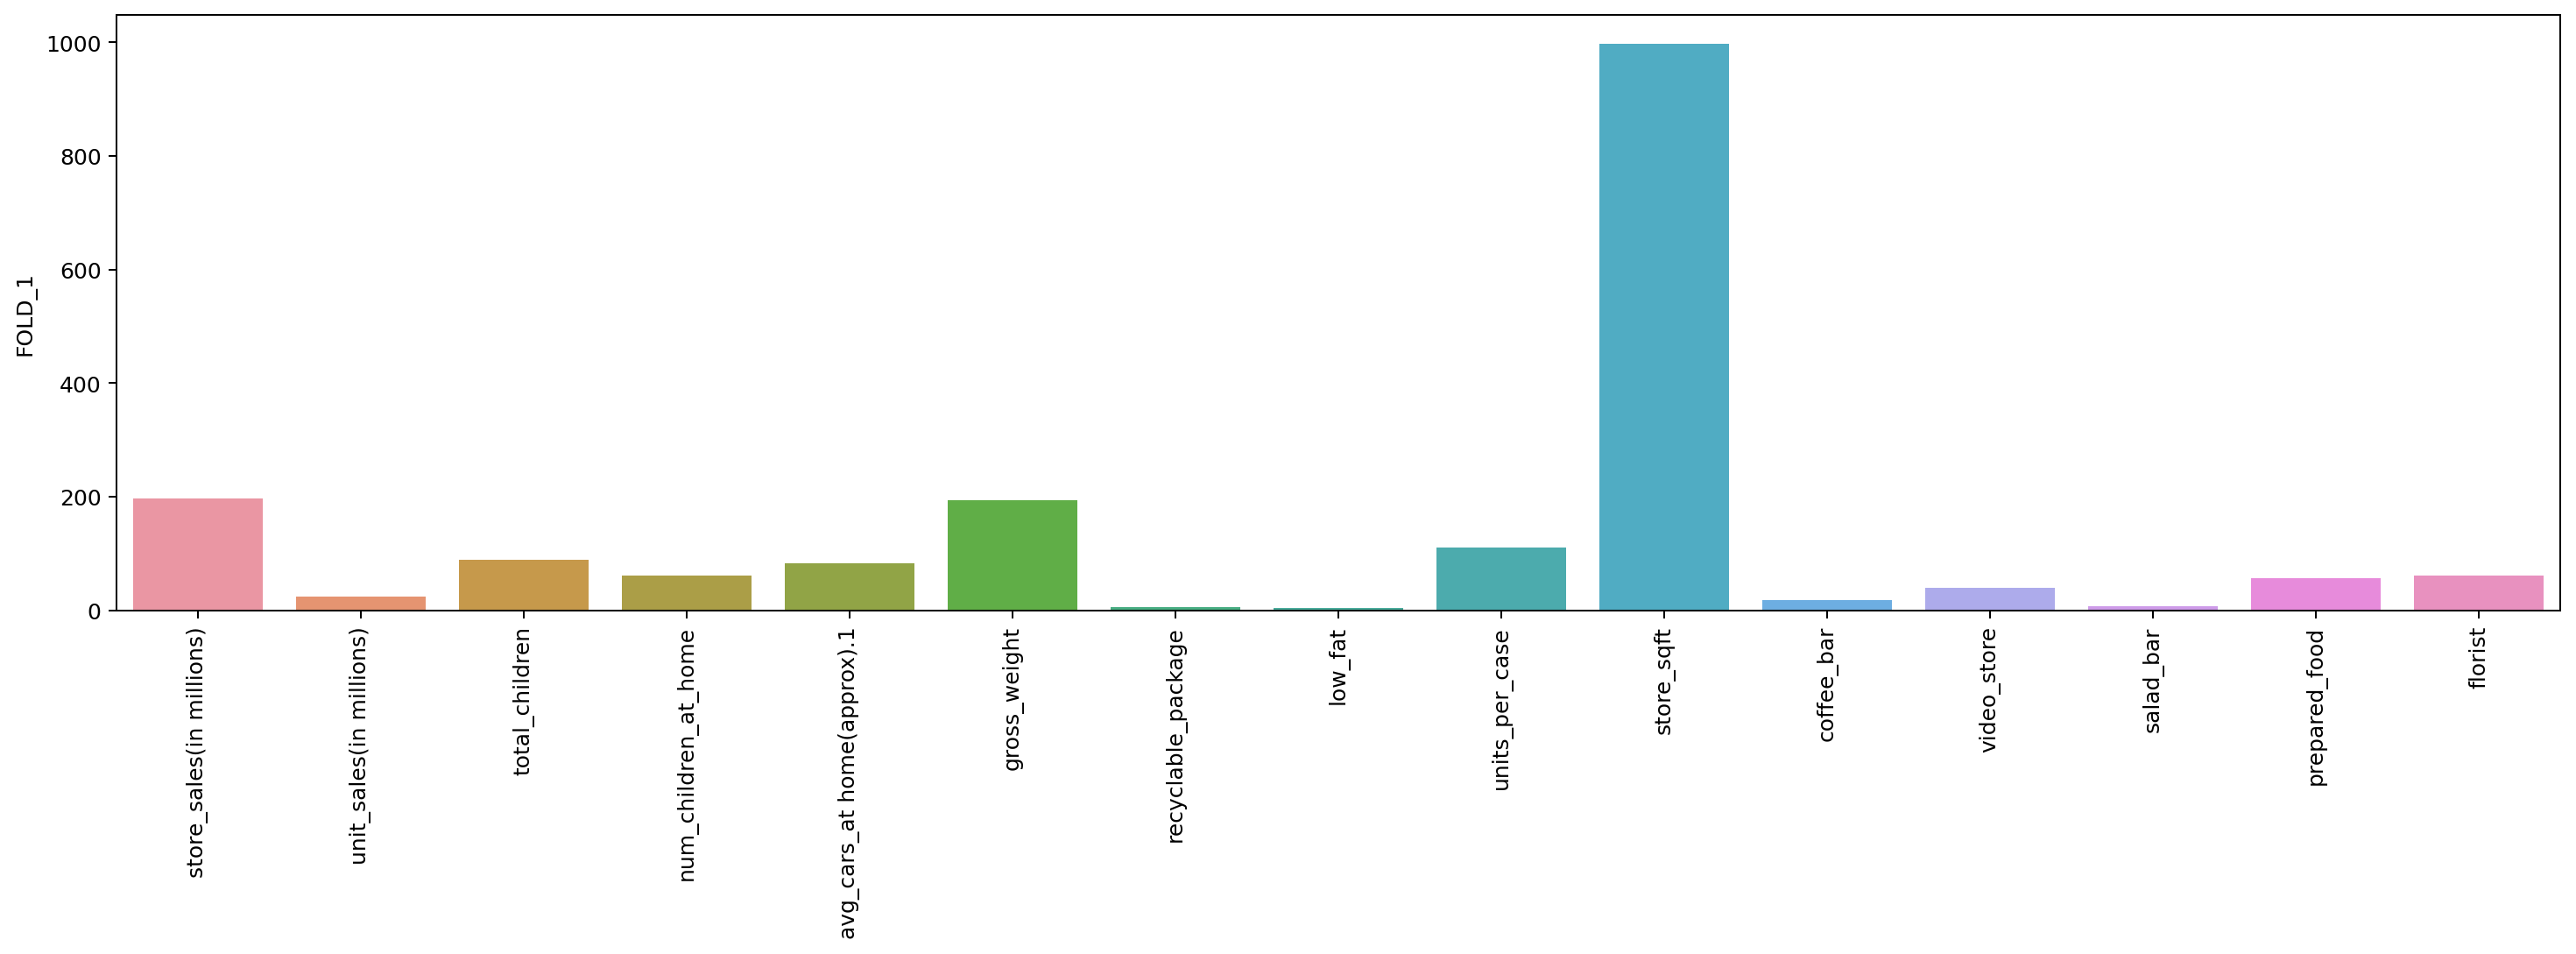

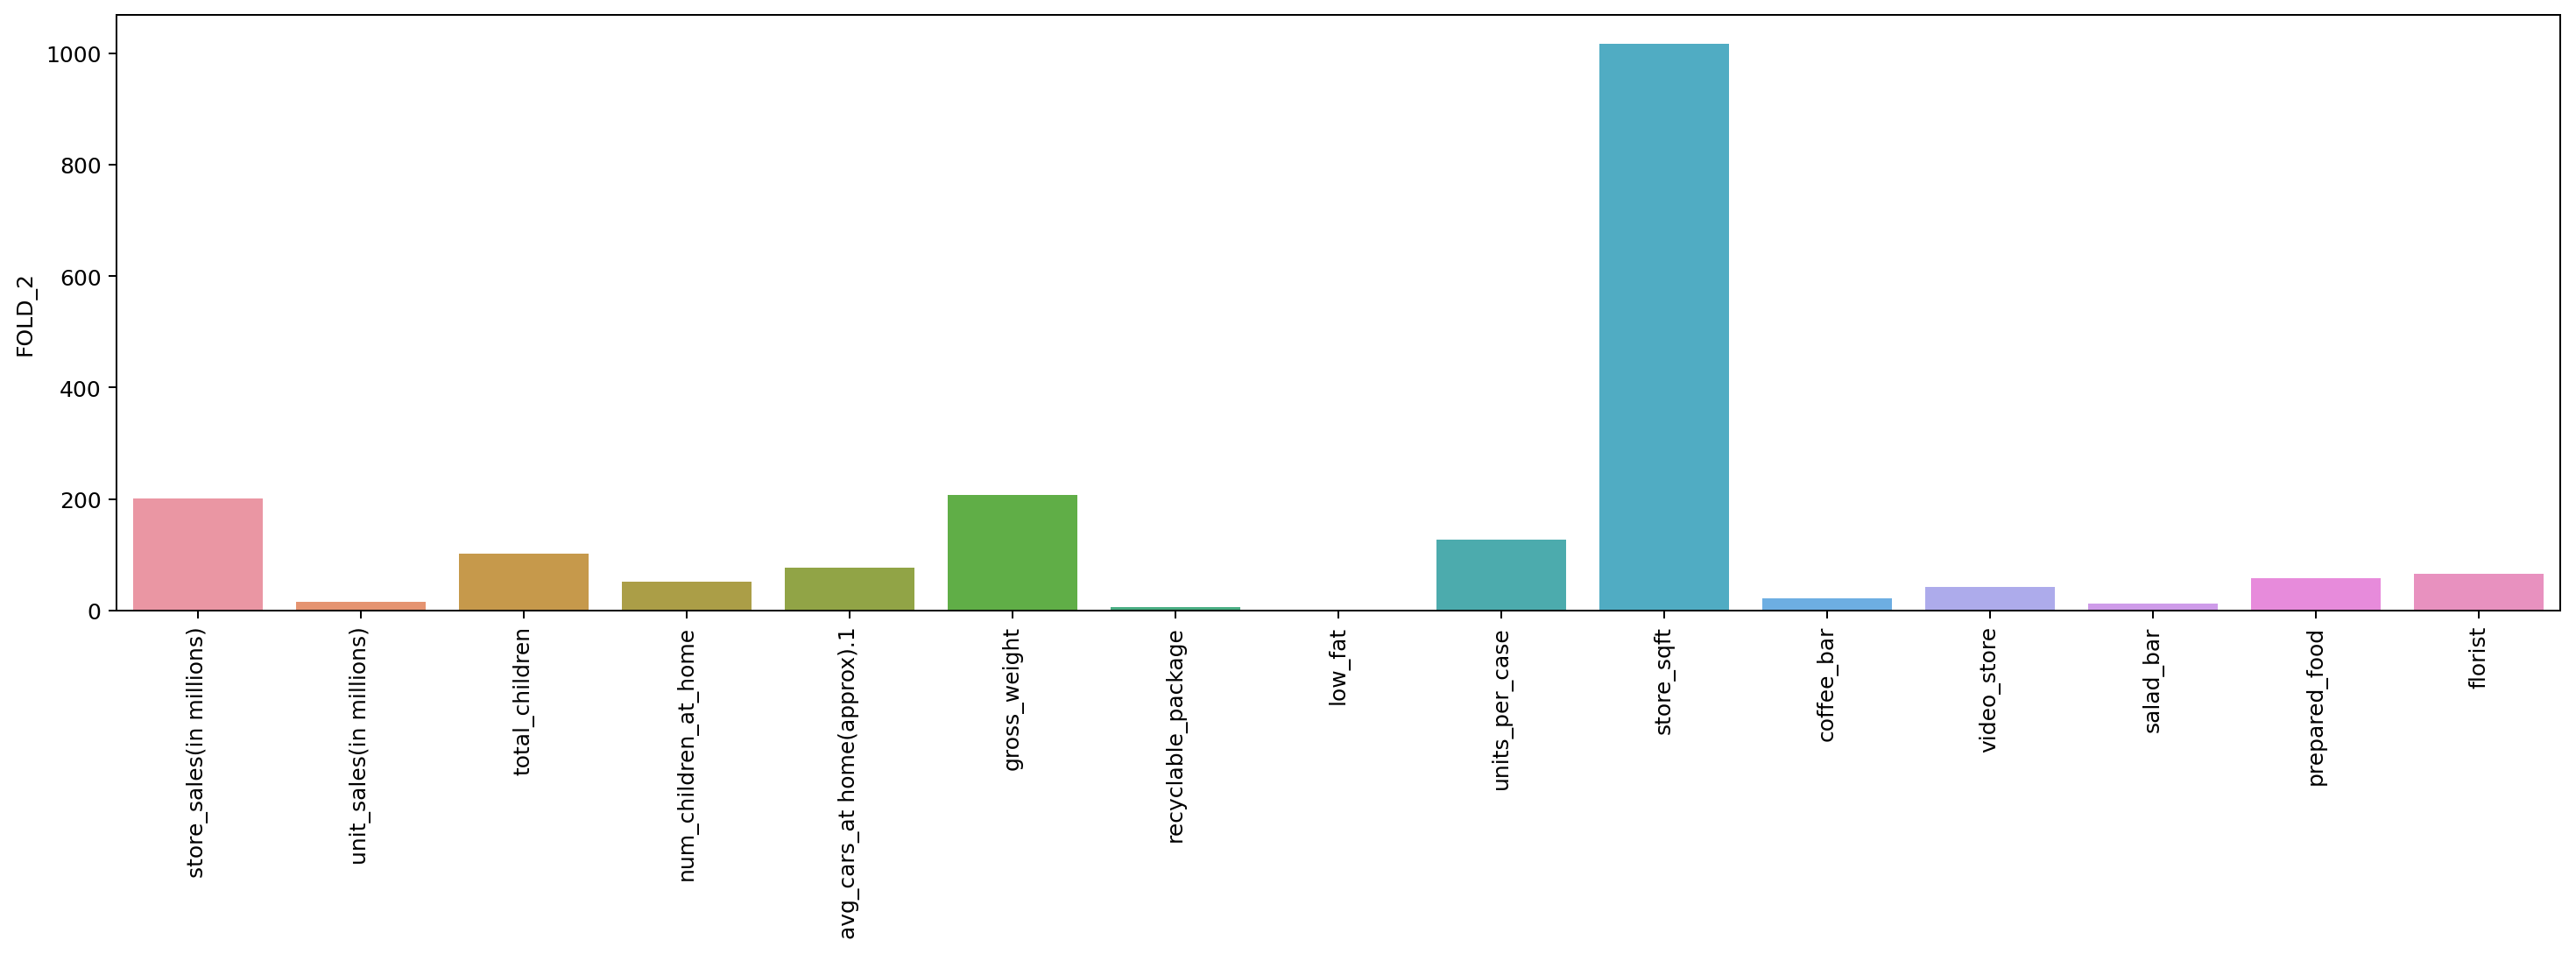

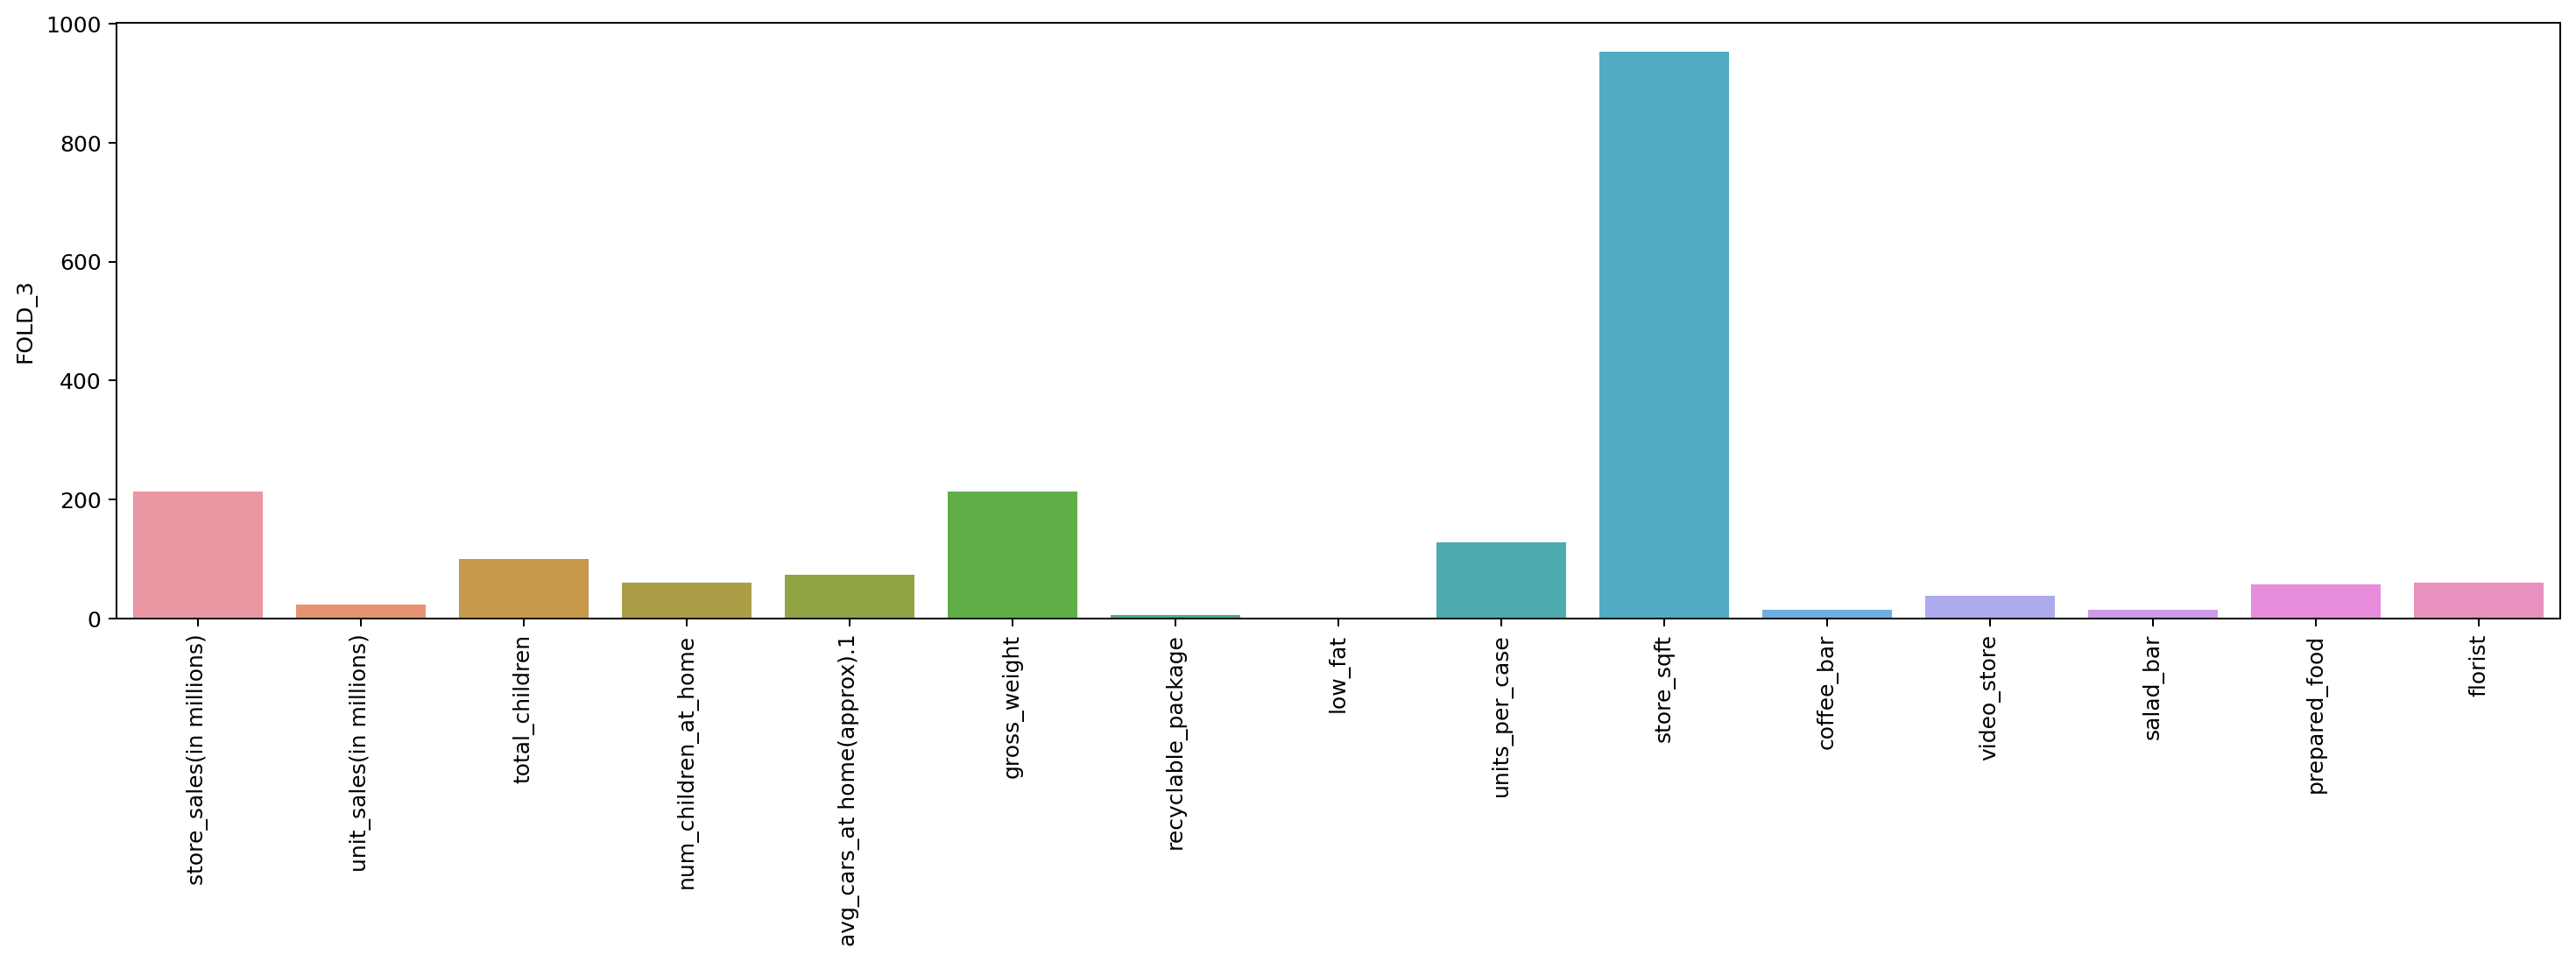

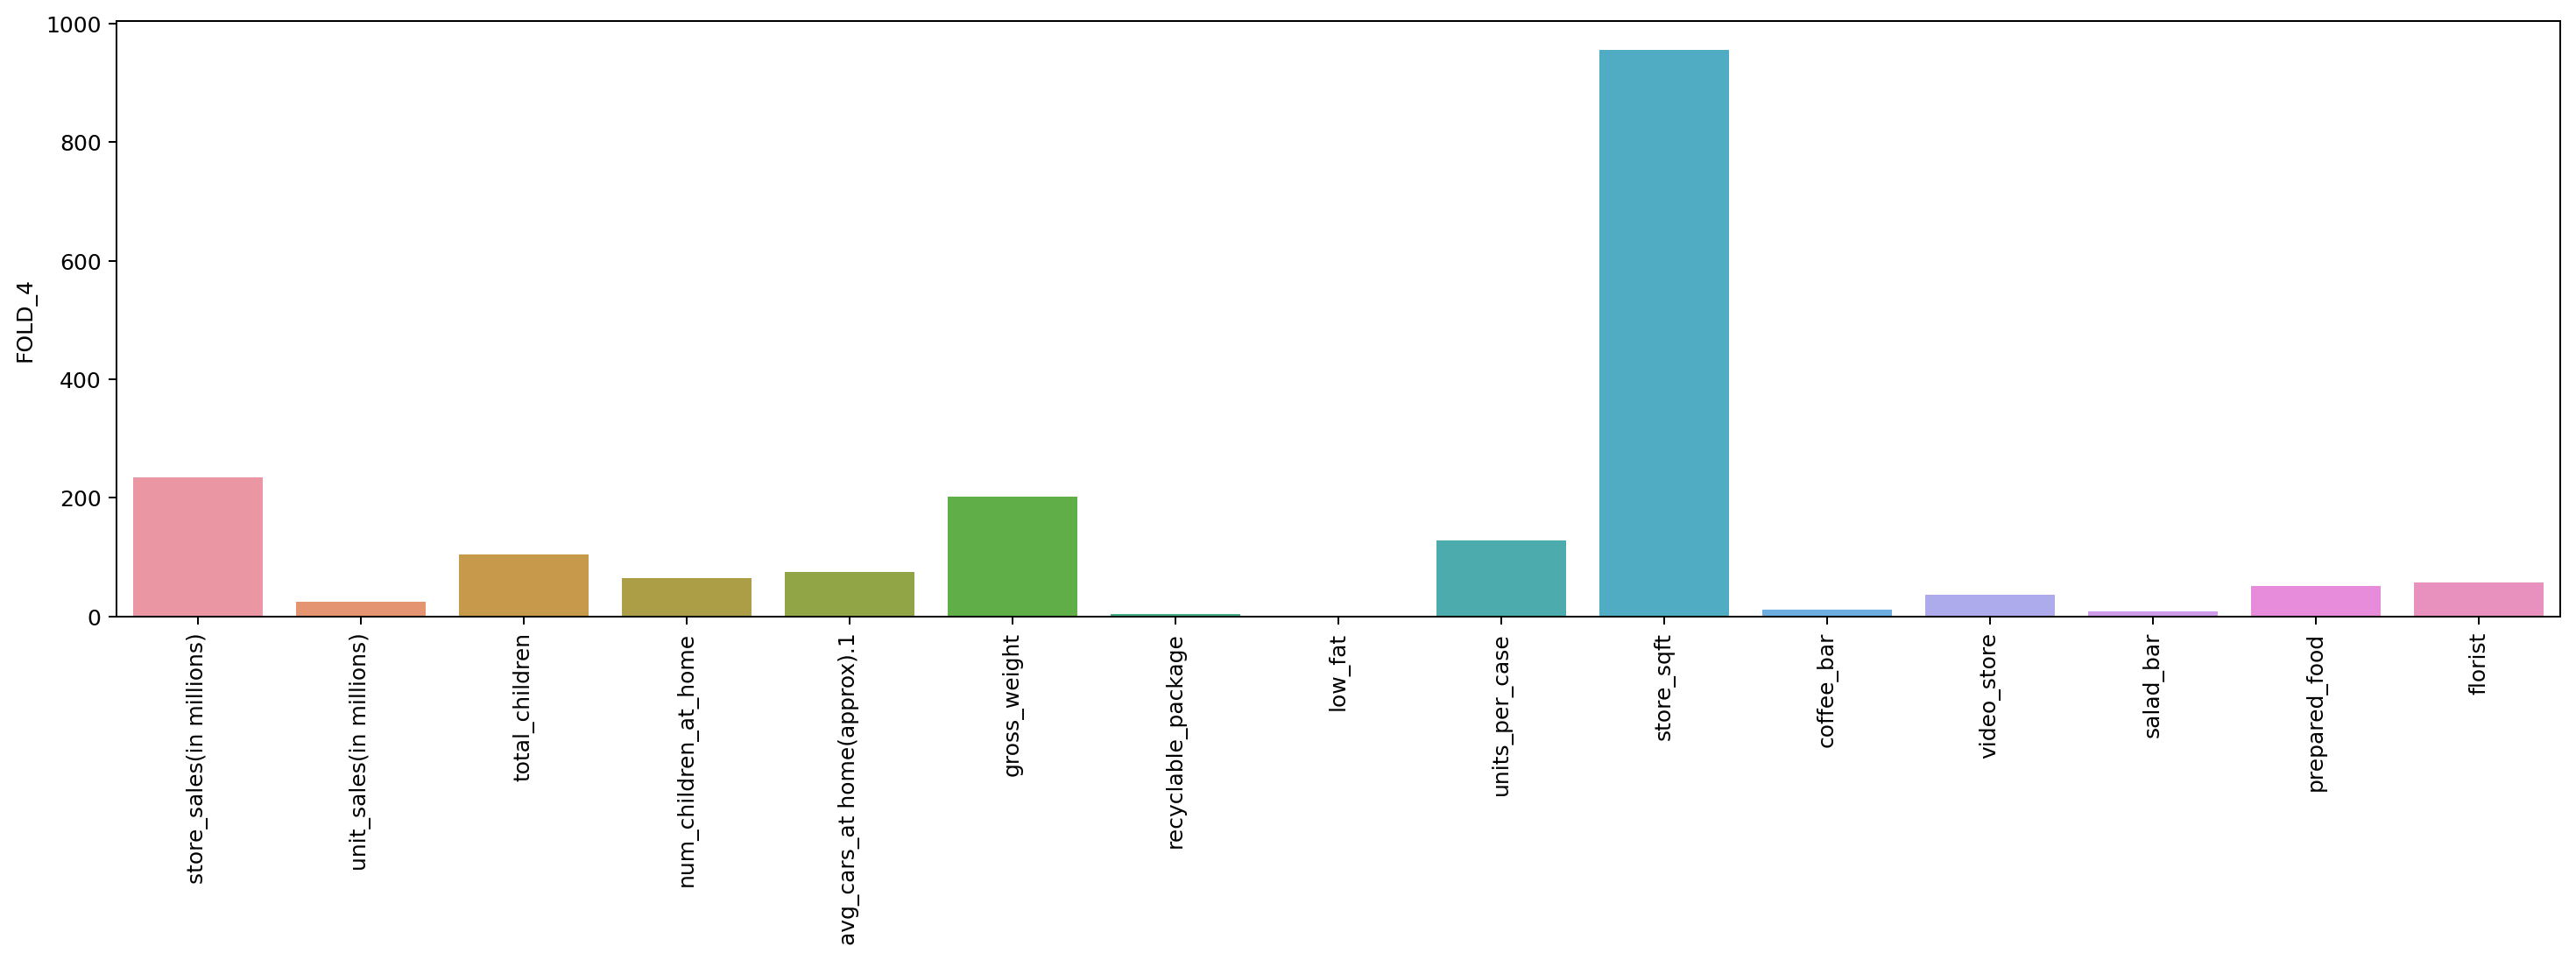

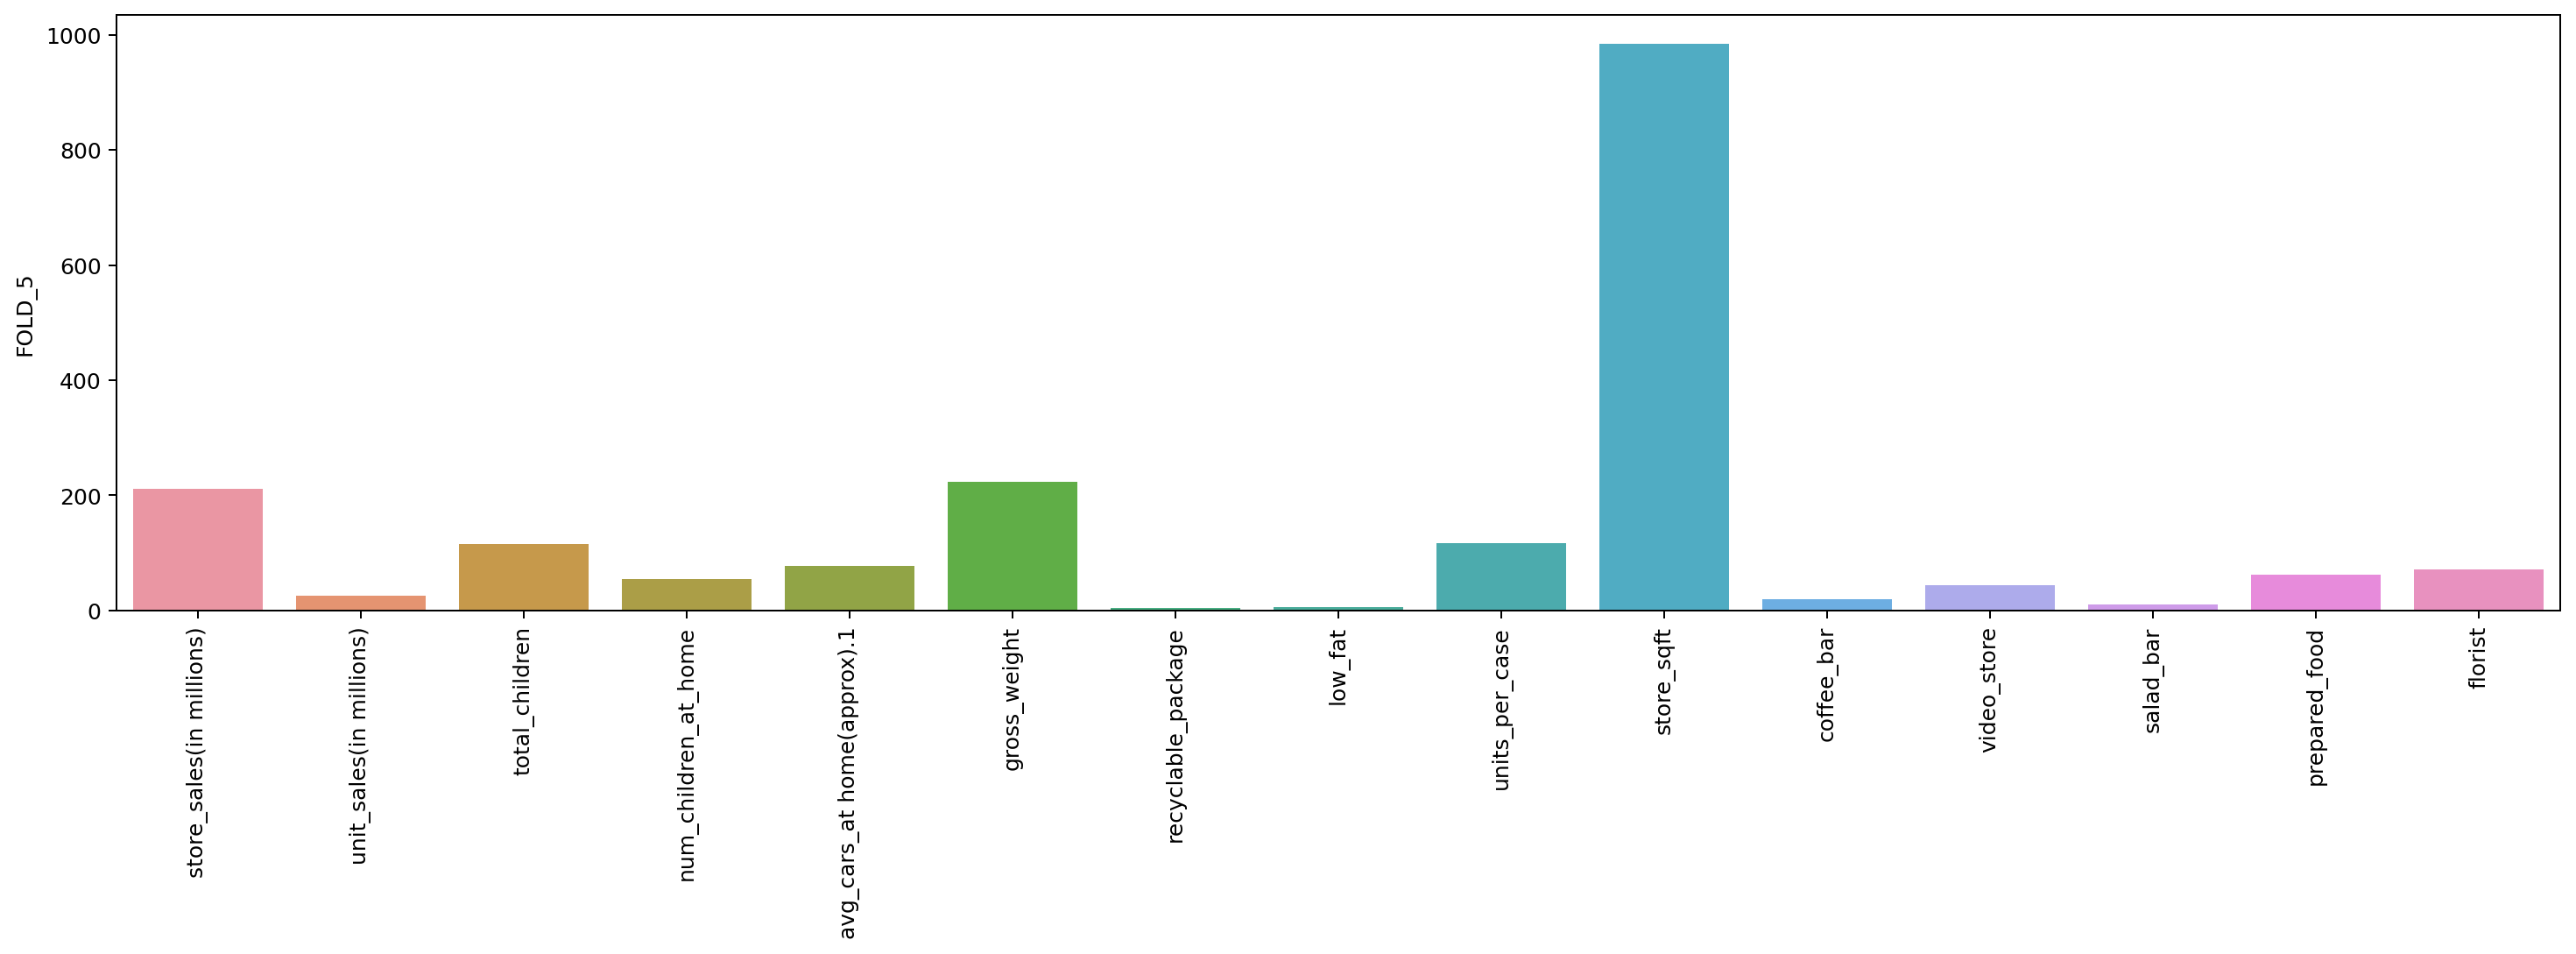

In [23]:
for col in df_importance.columns:
  fig = plt.figure(figsize=(20, 5), dpi=180)
  ax = fig.add_subplot(111)
  sns.barplot(x=df_importance.index, y=df_importance[col], ax=ax)
  plt.xticks(rotation=90)
  plt.show()

In [45]:
# now = datetime.now().astimezone(timezone('Asia/Tokyo'))

# submission = pd.read_csv("data/sample_submission.csv")
# submission["cost"] = df_preds["cost"].tolist()
# submission.to_csv(f"submissions/{now}-submission.csv", index=None)

In [46]:
# memo = ""

# pre = pd.read_csv("results/result.csv")
# df_result = pd.DataFrame([[now, "LightGBM", params, " ".join(FEATURES), np.mean(scores), , memo]])
# df_result.columns = ["date", "model", "params", "features", "val_RMSLE", "LB_RMSLE", "memo"]
# pd.concat([pre, df_result]).to_csv("results/result.csv", index=None)